## Vision Transformers (ViTs) Using Keras

In this notebook, we will build a CNN-Vision Transformer (ViT) hybrid image classification model. We will start by loading an existing CNN that is good at recogninzing small patterns in pictures. Then, we will lean how to improve it with a transformer, which helps the model see and use wider and more complex relationship in an image. The notebook covers important topics like preparing our image data, making our model smarter with both local and global learning, and saving our best results automatically. By the end, we will understand how CNN-ViT hybrid models work and how to train, evaluate, and visualize them for any image classification task.

This notebook demonstrated how to use custom-trained Keras CNN model to extract featyre maps and feed them into a ViT architecture.
1. Load the custom-trained CNN model
2. Extract feature maps from the CNN
3. Prepare tokend for the Vision Transformer
4. Build the Vision Transformer encoder
5. Train and evaluate the combined model

#### Step 1: Library imports and setup

In [49]:
%%time
import warnings
warnings.filterwarnings('ignore')
import os 
import time
import httpx 
import random
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
from datetime import datetime 
# def present_time():
#     return datetime.now().strftime("%Y%m%d_%H%M%S")

CPU times: total: 0 ns
Wall time: 64.8 μs


In [50]:
%%time
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import ModelCheckpoint

gpu_list = tf.config.list_physical_devices("GPu")
device = "gpu" if gpu_list != [] else "cpu"
print(f"Device available for training: {device}")

Device available for training: cpu
CPU times: total: 0 ns
Wall time: 329 μs


##### **Workflow**
1. We will start by loading a pre-trained CNN to act as a robust feature extractors for our image dataset.
2. After loading our CNN, we will select an intermediate feature map and reshape it into a sequence of tokens, getting our data ready for transformer-based learning.
3. We will add custom positional embeddings to our tokens so that the model can retain the original spatial structure of our images, even after the features have been flattened. 
4. Next, we will implement a Vision Transformer (ViT) encoder by stacking several transformer blocks, allowing our model to learn global relationships and context throughout the image. 
5. We will combine the CNN and ViT encoder into a single, hybrid model so that we can leverage both the local feature extraction power of CNNs and the global attention mechanism of transformers. 
6. When preparing our dataset, we will use Keras's ImageDataGenerator to handle data augmentation and to properly encode our labels for multi-class image classification.
7. We will set up a model checkpoint callback, letting our model automatically save its best weights whenever validation accuracy improves during traning, so we can always keep the most effective model.
8. To ensure everthing works smoothly, we will check the input and output shapes, which helps us catch architectural mistakes early. 
9. As our model trains, we will visualize both training and validation accuracy and loss, which will help us monitor performance and spot signs of overfitting or underfitting. 

#### Step 2: Load model

In [51]:
import os

data_dir = "."

keras_model_name = "ibm_ai_capstone_project.model.keras"
keras_model_path = os.path.join(data_dir, keras_model_name)

Reproducibility with random seeds

Here we fix the seeds for random module, NumPy, and TensorFlow. By initializing these seeds with a constant value, any operations the involve randomness (such as weight initialization, data shuffling, or data augmentation) will produce the exact same sequence of random numbers every time the code is run. This is crucial for ensuring the reproducibility of experiemntal resulsts and when comparing different models or hyperparameters.

In [52]:
# set seed 
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [53]:
cnn_model = tf.keras.models.load_model(keras_model_path)
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 930,821 (3.55 MB)

 Trainable params: 309,825 (1.18 MB)

 Non-trainable params: 1,344 (5.25 KB)

 Optimizer params: 619,652 (2.36 MB)

In [54]:
feature_layer_name = "batch_normalization_32"

#### Step 3: Custom positional embedding layer

In this cell, we will define a custom Keras layer called `AddPositionalEmbedding` that implements positional embeddings for the Vision Transformer architecture. Positional embeddings are crucial in transformer models because they lack inherent spatial awareness, unlike convolutional layers that have built-in spatial inductive biases.
- The class inherits form `layers.Layer`, making it a proper Keras custom layer.
- In the `__init__` method, it creates a trainable weight matrix using `self.add_weight()`.
- The positional embedding has shape `(1, num_patches, embed_dim)` where the first dimension allows broadcasting across batch sizes.
- The `initializer = "random_normal"` ensures the embeddings start with random values that will be learned during training.
- The `trainable = True` parameter makes these embeddings learnable parameters. 

This layer is essential for the hybrid CNN-ViT architecture because when CNN feature maps are flattened into tokens, spatial relationships are lost. The positional embeddings restore spatial awareness by providing each token with information about its original spatial location in the feature map. This allows the transformer to understand which tokens are spatially adjacent or distant, enabling it to make spatially aware attention decisions.

The `call` method adds the positional embeddings to the input tokens using element-wise addition. This is computationally efficient and follows the standard transformer approach, where positional information is added to preserve the embedding dimension.

In short: 
When you flatten CNN features into tokens, you lose spatial info (like “this patch was top-left”).
This layer puts that info back in, so the transformer can understand spatial relationships between patches.

In [55]:
# Positional embedding that Keras can track
@tf.keras.utils.register_keras_serializable(package="Custom")
class AddPositionalEmbedding(layers.Layer):
    def __init__(self, num_patches, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.embed_dim = embed_dim
        self.pos = self.add_weight(
            name="pos_emedding",
            shape=(1, num_patches, embed_dim),
            initializer="random_normal",
            trainable = True
        )
    
    def call(self, tokens):
        return tokens + self.pos 
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "embed_dim": self.embed_dim
        })
        return {**config}

#### Step 4: Transformer block implementation

In this code cell, we will implement a complete transformer encoder block, the fundamental building block of the Vision Transformer architecture. The `TransformerBlock` class encapsulates the standard transformer encoder architecture with multi-head self-attention and feed-forward neural network components.

**Role in hybrid architecture:** In the CNN-ViT hybrid, these transformer blocks process the tokenized CNN feature maps, allowing the model to capture long-range spatial dependencies that CNNs might miss due to their limited receptive fields. The self-attention mechanism enables each spatial location to attend to all other locations, providing global context awareness:

**Technical architecture:**
- *Multi-head attention (MHA)*: Uses `layers.MultiHeadAttention` with a configurable number of heads and key dimension equal to embed_dim.
- *Layer normalization*: Two `LayerNormalization` layers with epsilon = 1e-6 for numerical stability.
- *MLP block*: A two-layer feed-forward network with GELU activation and dropout for regularization.
- *Residual connections*: Implements skip connections around both the attention and MLP blocks.

**Parameters:**
- `embed_dim`: The dimensionality of token embeddings (typically matches CNN feature map channels)
- `num_heads`: Number of attention heads (default 8, must divide embed_dim evenly)
- `mlp_dim`: Hidden dimension of the MLP block (typically 4x embed_dim)
- `dropout`: Dropout rate for regularization (default 0.1)

**Forward pass logic**: Forward pass allows the model to capture both local and global dependencies in the feature representations while maintaining gradient flow through residual connections.

In [56]:
# One Transformer encoder block
@tf.keras.utils.register_keras_serializable(package="Custom")
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads=8, mlp_dim=2048, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads 
        self.mlp_dim = mlp_dim 
        self.dropout = dropout 
        self.mha = layers.MultiHeadAttention(num_heads, key_dim=embed_dim)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation="gelu"),
            layers.Dropout(dropout),
            layers.Dense(embed_dim),
            layers.Dropout(dropout)
        ])

    def call(self, x):
        x = self.norm1(x + self.mha(x, x))
        return self.norm2(x + self.mlp(x))
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "mlp_dim": self.mlp_dim,
            "dropout": self.dropout 
        })
        return {**config}

#### Step 5: Hybrid model builder function

Now, we will define a function `build_cnn_vit_hybrid` that constructs the complete hybrid CNN-Vision Transformer model. This function represents the main architectural innovation of the notebook, combining the strengths of CNNs for local feature extraction with transformers for global context modeling.

**Function architecture**: 
1. *CNN feature extraction*: Extracts intermediate feature maps from a pre-trained CNN at a specified layer.
2. *Tokenization*: Reshapes spatial feature maps into a sequence of tokens suitable for transformer processing
3. *Positional encoding*: Adds learnable positional embeddings to maintain spatial relationships
4. *Transformer stack*: Applies multiple transformer encoder blocks for global context modeling.
5. *Classification head*: Pools tokens and applies the final classification layer.

**Parameters**:
- `cnn_model`: Pre-trained CNN model for feature extraction
- `feature_layer_name`: Name of the CNN layer to extract features from (e.g, `batch_normalization` in the original model architecture)
- `num_transformer_layers`: Number of transformer blocks to stack (default 4)
- `num_heads`: Number of attention heads per transformer block (default 2048)
- `mlp_dim`: MLP hidden dimension in transformer blocks (default 2048)
- `num_classes`: Number of output classes for classification

The fucntion first freezes the CNN backbone (`cnn_model.trainable = False`) to use it as a fixed feature extractor. It then extracts feature maps with shape (B, H, W, C) [Batchsize, Height, Width, Channels] and reshapes them to (B, H*W, C), where each spatial location becomes a token. The `AddPositionEmbedding` layer adds spatial awareness, and multiple TransformerBlock layers process the tokens. Finally, `GlobalAveragePooling1D` aggregates all tokens, and a dense layer with softmax activation produces class predictions. 

This hybrid approach leverages CNN's local feature detection capabilities while adding the transformer's global attention mechanism. The result is a model that can capture both fine-grained local patterns and long-range spatial dependencies, potentially outperforming pure CNN or pure transformer approached on vision tasks.

In [67]:
def build_cnn_vit_hybrid(
        cnn_model, 
        feature_layer_name,
        num_transformer_layers=4,
        num_heads=8,
        mlp_dim=2048,
        num_classes=2
):
    # 1. Freeze or fine-tune the CNN.
    cnn_model.trainable = False

    # 2. Feature  extractor up to the chosen layer
    features = cnn_model.get_layer(feature_layer_name).output
    H, W, C = features.shape[1], features.shape[2], features.shape[3]

    # 3. Flatten spatial grid → tokens & add positional encoding 
    x = layers.Reshape((H * W, C))(features)
    x = AddPositionalEmbedding(H*W, C)(x)

    # 4. Stack ViT encoder blocks
    for _ in range(num_transformer_layers):
        x = TransformerBlock(C, num_heads, mlp_dim)(x)

    # 5. Token pooling & classification head
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return Model(cnn_model.layers[0].input, outputs, name="CNN_ViT_Hybrid")

#### Step 6: Data gemerator configuration 

Now we will set up data preprocessing and augmentation pipelime using Keras' `ImageDataGenerator`. 

**Data configuration parameters**: 
- `img_w, img_h =  64, 64`: Input image dimensions (64x64 pixels)
- `n_channels = 3`: RGB color channels 
- `batch_size = 128`: Number of samples per training batch
- `num_classes = 2`: Binary classification setup

**Generators**: Two seperate generators are created: 
1. `train_gen`: Training data with augmentation and shuffling.
2. `val_gen`: Validaiton data with the same preprocessing but a different subset. 

Both generators use `class_mode = "categorical"` for one-hot encoded labels, `target_size = (64, 64)` for consistent input dimensions, and `shuffle = True` for randomized batch sampling.

This augmentation strategy significantly increases the effective dataset size and helps prevent overfitting by exposing the model to varied versions of the same images. The validation split ensures proper model evaluation on unseen data, while the categorical class model prepares labels for softmax classification in the hybrid model.

In [58]:
dataset_path = os.path.join(data_dir, "images_dataSAT")
print(dataset_path)

.\images_dataSAT


In [59]:
img_w, img_h = 64, 64
n_channels = 3
batch_size = 128
num_classes = 2

datagen = ImageDataGenerator(
    rescale = 1./255, 
    rotation_range = 40,
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest",
    validation_split = 0.2
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size = (img_w, img_h),
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size = (img_w, img_h),
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "validation",
    shuffle = True
)

Found 4800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


#### Step 7: Model checkpoint setup

This code cell configures a `ModelCheckPoint` callback for saving the best model weights during training. Model checkpoiting is a crucial practice in deep learning that prevents loss of training progress and enables of the best-performing model state. 

**Checkpoint configuration**: 
- `filepath`: Specifies the file path and name for saving weights.
- `save_weights_only = True`: Saves only model weights, not the full model architecture (more efficient and avoids serialization issues)
- `monitor = 'val_accuracy'`: Track validation accuracy as the metric for determinig the "best" model 
- `mode = 'max'`: Indicates that higher validation accuracy values are better (use 'min' for loss metrics)
- `save_best_only = True`: Only saves the model when validation accuracy improves, preventing storage of worse-perfroming checkpoints. 
- `verbose = 1`: Provides console output when a checkpoint is saved.

The checkpoint callback addresses several important training considerations:
1. *Overfitting preventing*: Captures the model state at peak validation performance before overfitting occurs.
2. *Storage efficiency*: Saving weights only reduces files size compares to full model serialization
3. *Automatic model saving*: Eliminates manual monitoring by automatically saving the best-performing epoch 

Integration with training: This callback will be passed to the `model.fit()` method, where it will monitor validation accuracy after each epoch. When validation accuracy improves, the callback saves the current model weights to the specified file. This ensures that even if training continues past the optimal point, the best-performing wegihts are preserved. 

File name convention: The filename uses the `.model.keras` extension to indicate it contains the full model architecture.

In [60]:
class CustomPrintCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        # Print epoch number and starting time
        print(f"Epoch {(epoch + 1):.02d} completed on {present_time()}")
time_print_callback = CustomPrintCallback()

In [61]:
model_name = "keras_cnn_vit.model.keras"

# Save only weights to overcome the serialization issues with the hybrid model. The full model can be saved using the model architecture and weights.
checkpoint_cb = ModelCheckpoint(
    filepath = model_name,
    save_weights_only = False, # Set to True to save only weights
    monitor = 'val_accuracy', # or 'val_loss'
    mode = 'max', # 'min' for loss, 'max' for accuracy
    save_best_only = True,
    verbose = 1
)

#### Step 8: Model training and compilation

We will now set up the core training pipiline, where the hybrid CNN-ViT model is build, compiled, and trained. This is the complete workflow from model instantiation to training execution with proper configuration for multi-class classification. 

In [71]:
hybrid_model = build_cnn_vit_hybrid(
     cnn_model, 
     feature_layer_name=feature_layer_name, 
     num_transformer_layers=4, 
     num_heads=8,
     mlp_dim=2048,
     num_classes=2
    )

# # or a cleaner version 

# num_classes = train_gen.num_classes
# hybrid_model = build_cnn_vit_hybrid(
#         cnn_model,
#         feature_layer_name=feature_layer_name,
#         num_transformer_layers=4,
#         num_heads=8,
#         mlp_dim=2048,
#         num_classes=train_gen.num_classes)

In [76]:
hybrid_model.compile(
    optimizer = tf.keras.optimizers.Adam(0.0001),
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

##### Model shape validation 

This code cell performs the validation step to ensure the hybrid model produces outputs with the correct shape and dimensions. Shape validation is essential in deep learning to catch architectural errors early and verify that the model will work correctly with the expected input and output formats. 

**Validation process**: The cell creates a dummy input tensor using `tf.random.normal([1, img_w, img_, n_channels])`, which generates random values with the same shape as actual input images:
- Batch size: 1 (single sample for testing)
- Width: `img_w` (64 pixels)
- Height: `img_h` (64 pixels)
- Channels: `n_channels` (3 for RGB)

**Output verification**: The dummy input is passed through the hbrid model (`hynrid_model(dummy)`) to generate predictions. The expected output shape should be `(1, num_classes)` where:
- First dimension (1): Batch size
- Second dimension (`num_classes`): Number of classification classes

**Technical benefits**: This validation step serves multiple purposes:
1. **Architecture verification**: Confirms that all layers are properly connected and compatible.
2. **Dimension checking**: Ensures the model produces the expected output shape for classification.
3. **Early error detection**: Catches shape mismatches before actual training or inference
4. **Model readiness**: Verifies the model is ready for proeuction use

**Importance**: If the output shape doesn't match expectations, it indicates potential issuses in the hybrid architecture, such as incorrect reshaping operations, wrong number of classes configuration, or problems in the CNN-to-transformer transition. This simple test can save significant debugging time by catching architectural issues immediately after model construction.


In [77]:
# Ensure end-to-end shapes line up
dummy = tf.random.normal([1, img_w, img_h, n_channels])
pred = hybrid_model(dummy)
print("Logits shape: ", pred.shape)

Logits shape:  (1, 2)


In [84]:
n_epochs = 3

fit = hybrid_model.fit(
    train_gen,
    epochs = n_epochs,
    steps_per_epoch = 128,
    validation_data = val_gen,
    callbacks = [checkpoint_cb],
    verbose = 1
)

Epoch 1/3
 38/128 ━━━━━━━━━━━━━━━━━━━━ 4:56 3s/step - accuracy: 0.9951 - loss: 0.0148
Epoch 1: val_accuracy did not improve from 0.99083
128/128 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9929 - loss: 0.0193 - val_accuracy: 0.9900 - val_loss: 0.0245
Epoch 2/3
 38/128 ━━━━━━━━━━━━━━━━━━━━ 4:57 3s/step - accuracy: 0.9938 - loss: 0.0156
Epoch 2: val_accuracy did not improve from 0.99083
128/128 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9942 - loss: 0.0165 - val_accuracy: 0.9908 - val_loss: 0.0258
Epoch 3/3
 38/128 ━━━━━━━━━━━━━━━━━━━━ 4:49 3s/step - accuracy: 0.9923 - loss: 0.0242
Epoch 3: val_accuracy did not improve from 0.99083
128/128 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.9912 - loss: 0.0244 - val_accuracy: 0.9892 - val_loss: 0.0304


#### Step 8: Training results visualization 

This code cell creates comprehensive visualizations of the training process by plotting both accuracy and loss curves. Visualization of training metrics is essential for understanding model performance, diagnosing training issues, and making informed decision about model optimization. 

1. Overfitting detection: Diverging training and validation curves indicate overfitting.
2. Convergence assessment: Plateauing curves suggest training completion.
3. Learning rate evaluation: Oscillating curves may indicate learning rate issues.
4. Model performance: Final accuracy and loss values indicate overall model quality.

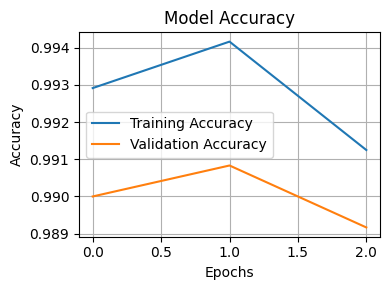

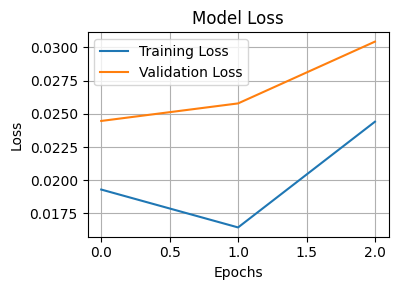

In [85]:
# Create a figure with a subplot
fig_w, fig_h = 4,3
fig, axs = plt.subplots(figsize=(fig_w, fig_h ))

# Plot Accuracy on the first subplot
axs.plot(fit.history['accuracy'], label='Training Accuracy')
axs.plot(fit.history["val_accuracy"], label = "Validation Accuracy")
axs.set_title('Model Accuracy')
axs.set_xlabel('Epochs')
axs.set_ylabel('Accuracy')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()


## You can use this cell to type the code to complete the task.

fig, axs = plt.subplots(figsize=(fig_w, fig_h ))

# Plot Loss on the second subplot
axs.plot(fit.history['loss'], label='Training Loss')
axs.plot(fit.history['val_loss'], label='Validation Loss')
axs.set_title('Model Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()